## Introduction

Dans ce Notebook, nous sélectionnons des images qui possèdent des segments non-disjoints.<br>
Nous réduisons leurs dimensions (525 x 350) et nous labellisons le jeu de données à l'aide d'une _Bouding Box_<br>
pour la phase d'apprentissage (Détection d'objet à l'aide de TensorFlow)

## 1. Importation des librairies

In [7]:
%matplotlib inline
%run utils_explo_prepa.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os

## 2. Préparation du jeu de données

### Réduction de la taille des images (Optional)

In [ ]:
##############################################################################
### Optional : Réaliser cette étape si les fichiers réduits n'existent pas ###
##############################################################################
if False:
    df = pd.read_csv('clouds_1.csv')
    ImageIds = df.apply(lambda row: row['ImageId'].split('_')[0], axis=1).unique()
    for imageid in ImageIds:
        small_img = reduceImages(imageid, 'images/', (525, 350))
        new_path = 'images/small/' + imageid + '.jpg'
        cv2.imwrite(new_path, small_img)

### Chargement du jeu de données enrichi

In [2]:
IS_LARGE_DATA_SET = True

if IS_LARGE_DATA_SET:
    df = pd.read_csv('clouds_1_large.csv')
else:
    df = pd.read_csv('clouds_1_small.csv')
    
df.head(10)

,ImageId,FileId,EncodedPixels,EncodedPixelsCount,MeanPixelsCloud,StdPixelsCloud,CountPixelsHiddenArea,RatioHiddenArea,CloudRatio,X,Y,W,H,ResizedMaskPixelsCount,BoundingBoxPixelsCount,BoxMaskGap,Label,Class
0,0011165_0,0011165,264918 937 266318 937 267718 937 269118 937 27...,932312,61.81,55.64,119052.0,0.04,0.317113,171.5,196.5,249,235,58264,58515,0.004308,Fish,0
1,0011165_1,0011165,1355565 1002 1356965 1002 1358365 1002 1359765...,1156107,105.11,55.77,119052.0,0.04,0.393234,383.0,210.0,282,264,72174,74448,0.031507,Flower,1
2,002be4f_0,002be4f,233813 878 235213 878 236613 878 238010 881 23...,1684325,85.52,65.56,76901.0,0.03,0.572900,282.0,112.5,480,221,105077,106080,0.009545,Fish,0
3,002be4f_1,002be4f,1339279 519 1340679 519 1342079 519 1343479 51...,592697,82.66,64.96,76901.0,0.03,0.201598,382.0,284.0,286,130,36765,37180,0.011288,Flower,1
4,002be4f_3,002be4f,67495 350 68895 350 70295 350 71695 350 73095 ...,313950,56.97,26.75,76901.0,0.03,0.106786,124.0,117.0,224,88,19488,19712,0.011494,Sugar,3
5,0031ae9_0,0031ae9,3510 690 4910 690 6310 690 7710 690 9110 690 1...,1240822,91.41,63.64,405071.0,0.14,0.422048,227.5,263.5,455,173,77642,78715,0.013820,Fish,0
6,0031ae9_1,0031ae9,2047 703 3447 703 4847 703 6247 703 7647 703 9...,1178858,88.26,60.31,405071.0,0.14,0.400972,186.0,231.0,372,212,73434,78864,0.073944,Flower,1
7,0031ae9_3,0031ae9,658170 388 659570 388 660970 388 662370 388 66...,306908,39.62,34.98,405071.0,0.14,0.104390,216.0,90.5,198,97,19109,19206,0.005076,Sugar,3
8,0035239_1,0035239,100812 462 102212 462 103612 462 105012 462 10...,655989,55.80,45.39,417128.0,0.14,0.223126,135.0,93.0,234,180,40830,42120,0.031594,Flower,1
9,0035239_2,0035239,65400 380 66800 380 68200 380 69600 380 71000 ...,289939,55.32,45.45,417128.0,0.14,0.098619,106.5,297.5,191,95,18049,18145,0.005319,Gravel,2


### Dénombrement des observations masquées de façon significative par une barre noire (plus de 20% de l'image)

In [3]:
df_hidden = df[df['RatioHiddenArea'] > 0.2][['FileId', 'CountPixelsHiddenArea', 'RatioHiddenArea']].groupby('FileId').agg({'CountPixelsHiddenArea': lambda x: x.mode().iloc[0], 'RatioHiddenArea': lambda x: x.mode().iloc[0]}).reset_index()
df_hidden = df_hidden.sort_values(by='RatioHiddenArea', ascending=False)
df_hidden

,FileId,CountPixelsHiddenArea,RatioHiddenArea
11,9925939,2940000.0,1.00
4,24884e7,2508802.0,0.85
13,f32724b,2347138.0,0.80
5,3b9a092,2142624.0,0.73
9,5265e81,1752587.0,0.60
7,400a38d,1620934.0,0.55
12,a2dc5c0,1425797.0,0.48
3,17fe76e,1308357.0,0.45
10,838cd7a,1064727.0,0.36
14,fd5aa5d,886089.0,0.30


In [4]:
df = df[df['FileId'].apply(lambda x: all(exclude not in x for exclude in df_hidden['FileId'].tolist()))]
df

,ImageId,FileId,EncodedPixels,EncodedPixelsCount,MeanPixelsCloud,StdPixelsCloud,CountPixelsHiddenArea,RatioHiddenArea,CloudRatio,X,Y,W,H,ResizedMaskPixelsCount,BoundingBoxPixelsCount,BoxMaskGap,Label,Class
0,0011165_0,0011165,264918 937 266318 937 267718 937 269118 937 27...,932312,61.81,55.64,119052.0,0.04,0.317113,171.5,196.5,249,235,58264,58515,0.004308,Fish,0
1,0011165_1,0011165,1355565 1002 1356965 1002 1358365 1002 1359765...,1156107,105.11,55.77,119052.0,0.04,0.393234,383.0,210.0,282,264,72174,74448,0.031507,Flower,1
2,002be4f_0,002be4f,233813 878 235213 878 236613 878 238010 881 23...,1684325,85.52,65.56,76901.0,0.03,0.572900,282.0,112.5,480,221,105077,106080,0.009545,Fish,0
3,002be4f_1,002be4f,1339279 519 1340679 519 1342079 519 1343479 51...,592697,82.66,64.96,76901.0,0.03,0.201598,382.0,284.0,286,130,36765,37180,0.011288,Flower,1
4,002be4f_3,002be4f,67495 350 68895 350 70295 350 71695 350 73095 ...,313950,56.97,26.75,76901.0,0.03,0.106786,124.0,117.0,224,88,19488,19712,0.011494,Sugar,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11831,ffd11b6_3,ffd11b6,1457936 458 1459336 458 1460736 458 1462136 45...,197398,66.89,42.09,298517.0,0.10,0.067142,314.0,191.0,108,114,12312,12312,0.000000,Sugar,3
11832,ffd3dfb_3,ffd3dfb,12891 428 14291 428 15691 428 17091 428 18491 ...,1239092,60.23,38.23,369145.0,0.13,0.421460,232.5,140.5,461,209,77430,96349,0.244337,Sugar,3
11833,ffd6680_1,ffd6680,1509467 305 1509773 7 1509782 2 1510867 310 15...,1094336,103.53,56.99,414995.0,0.14,0.372223,397.0,208.0,256,284,68104,72704,0.067544,Flower,1
11834,ffd6680_2,ffd6680,39728 823 41128 823 42528 823 43928 823 45328 ...,628719,42.69,35.60,414995.0,0.14,0.213850,103.0,235.0,192,206,39173,39552,0.009675,Gravel,2


### Echantillonage des images avec masques non-disjoints

In [ ]:
IS_SELECT_ADJACENT = True
GAP_LIMIT_LOW = 0
GAP_LIMIT_HIGH = 0.09 # (< 0.09 -> 9%)

if IS_SELECT_ADJACENT:
    df = df[(df['BoxMaskGap'] >= GAP_LIMIT_LOW) & (df['BoxMaskGap'] < GAP_LIMIT_HIGH)]
    
df.info()

## 4. Exploration du jeu de données

### Positionnement spatial des zones d'intérêt

In [ ]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.hist(sample.X, range=(0, 499), bins=20, rwidth=0.8)
plt.xlabel('X')
plt.ylabel('Count')
plt.subplot(122)
plt.hist(sample.Y, range=(0, 349), bins=20, rwidth=0.8)
plt.xlabel('Y')
plt.ylabel('Count');

## Les bounding boxes se répartissent de façon à peu près homogène dans l'image

In [ ]:
fig = plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.hist(sample.W, range=(0, 499), bins=20, rwidth=0.8)
plt.xlabel('W')
plt.ylabel('Count')
plt.subplot(122)
plt.hist(sample.H, range=(0, 349), bins=20, rwidth=0.8)
plt.xlabel('H')
plt.ylabel('Count');

## Les Bounding boxes sont généralement de taille relativement faibles

## 5. Visualisation du jeu de données

### Visualisation des images d'orine

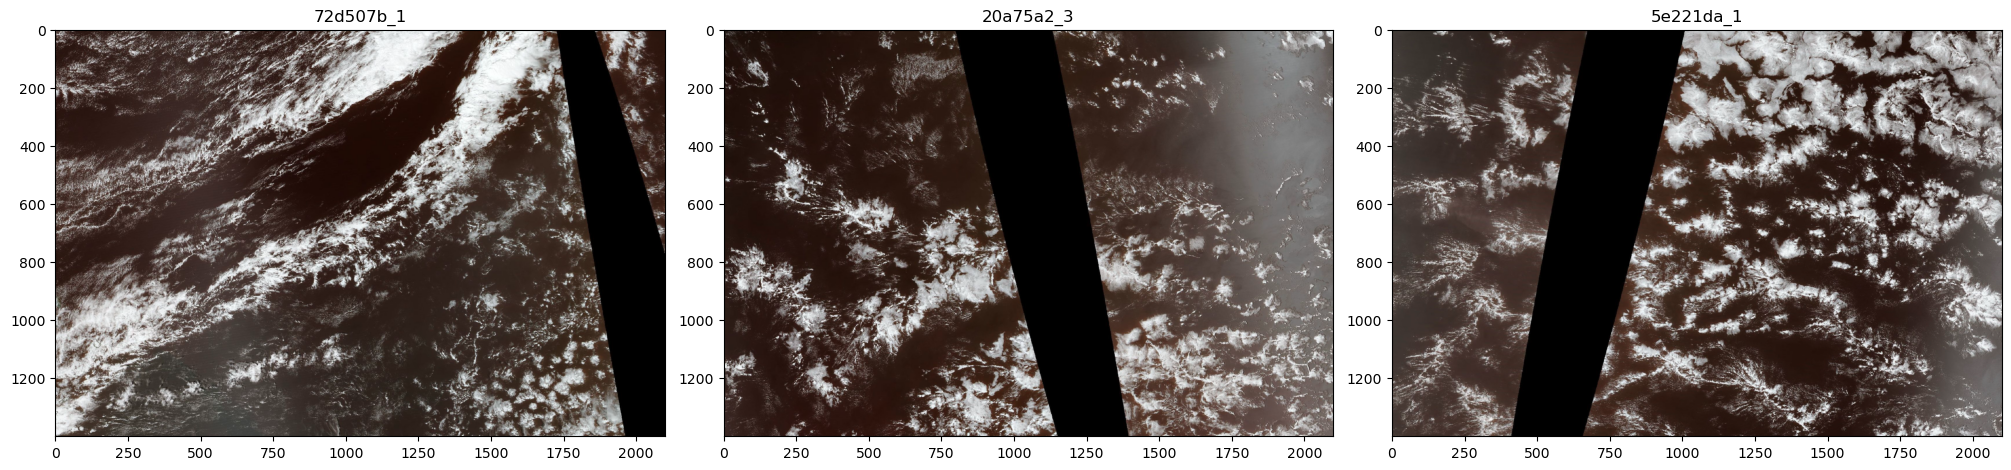

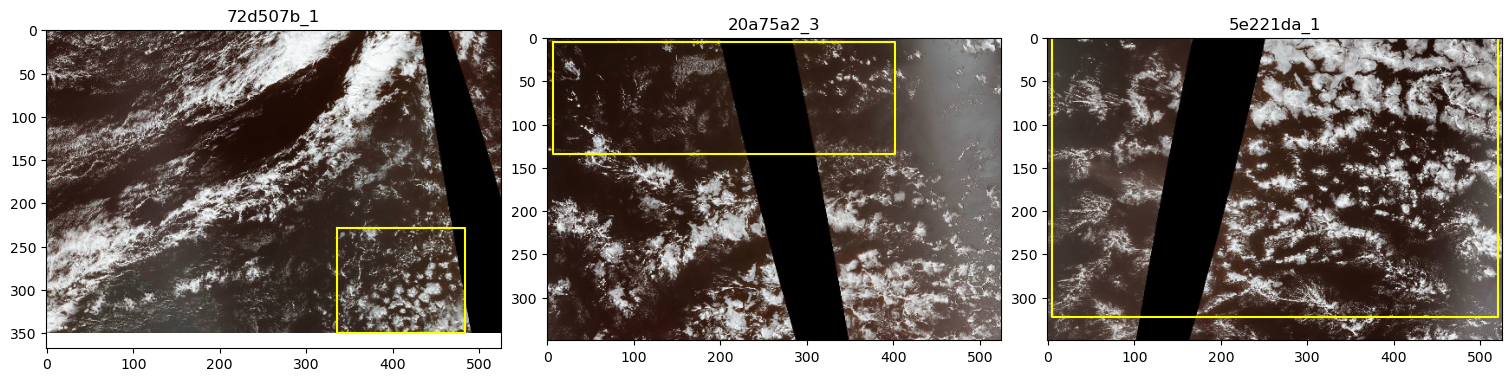

In [6]:
ImageIds = random.sample(df['ImageId'].unique().tolist(), 3)
showImages(ImageIds, 1, 3, df, 2100, 1400, 'images/', hide_axis=False, show_mask=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 20), layout='constrained')
for axe, img_id in zip(axes.flat, ImageIds):
    x = df[df['ImageId'] == img_id].X
    y = df[df['ImageId'] == img_id].Y
    w = df[df['ImageId'] == img_id].W
    h = df[df['ImageId'] == img_id].H
    displayBoundingBox(img_id, axe, x, y, w, h)
plt.show()